<a href="https://colab.research.google.com/github/Kennenzz/predict-employee-attrition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**XÂY DỰNG MÔ HÌNH DỰ ĐOÁN NGUY CƠ NGHỈ VIỆC CỦA NHÂN VIÊN**
---

**#Import các thư viện sẽ sử dụng trong đồ án bao gồm:**
*   **Pandas**
*   **Numpy**
*   **Matplotlib**
*   **Seaborn**

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

---
**Đọc file dataset**

In [25]:
try:
    df = pd.read_csv("Dataset.csv")
    display(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dataset trong dữ liệu folder")
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


---
**Mô tả tổng quan về dataset**

In [26]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 35)

**Tổng quan: Dataset thông tin của nhân viên gồm có 1470 mẫu và 35 cột (thuộc tinh)**


---
# Phân loại các biến trong dataset

In [27]:
# cần run file từ đầu đến cuối
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

print("Biến số:")
display(numerical_cols)

print("\nBiến phân loại:")
display(categorical_cols)

Biến số:


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


Biến phân loại:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

---
**Tiền xử lý dữ liệu**

In [28]:
# Xử lý chuẩn hóa dữ liệu
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển đổi sang kiểu số, lỗi sẽ thành NaN
    if df[col].isnull().any():
        print(f"Cảnh báo: Cột '{col}' có giá trị không thể chuyển đổi sang số.")
    print(f"Cột '{col}' đã được chuyển đổi sang kiểu số.")


for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}': {unique_values}")
    df[col] = df[col].str.strip().str.lower()   # Loại bỏ khoảng trắng và chuyển về chữ thường  
    unique_values_after = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}' sau khi xử lý: {unique_values_after}")

Cột 'Age' đã được chuyển đổi sang kiểu số.
Cột 'DailyRate' đã được chuyển đổi sang kiểu số.
Cột 'DistanceFromHome' đã được chuyển đổi sang kiểu số.
Cột 'Education' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeCount' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeNumber' đã được chuyển đổi sang kiểu số.
Cột 'EnvironmentSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'HourlyRate' đã được chuyển đổi sang kiểu số.
Cột 'JobInvolvement' đã được chuyển đổi sang kiểu số.
Cột 'JobLevel' đã được chuyển đổi sang kiểu số.
Cột 'JobSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyIncome' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyRate' đã được chuyển đổi sang kiểu số.
Cột 'NumCompaniesWorked' đã được chuyển đổi sang kiểu số.
Cột 'PercentSalaryHike' đã được chuyển đổi sang kiểu số.
Cột 'PerformanceRating' đã được chuyển đổi sang kiểu số.
Cột 'RelationshipSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'StandardHours' đã được chuyển đổi sang kiểu số.
Cột 'StockOptionLevel' đã được ch

Xử lý dữ liệu thiếu

In [29]:
df.isnull().sum()


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

*Không có dữ liệu thiếu trong dataset*

*Xử lý dữ liệu dư thừa, dữ liệu gây nhiễu (không liên quan)*

In [30]:
df.drop(columns=['Over18', 'EmployeeNumber', 'EmployeeCount','StandardHours'], axis =1, inplace= True)
# Cập nhật lại danh sách biến phân loại sau khi loại bỏ cột
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

Qua quan sát dữ liệu thì có thể thấy các cột dữ liệu không cần thiết như sau:
*   **Over18** tất cả nhân viên đều đã trên 18 tuổi
*   **EmployeeCount** luôn có giá trị là 1
*   **EmployeeNumber** luôn có giá trị khác nhau như việc nhân viên có mã nhân viên
*   **StandardHours** luôn có giá trị là 80

In [31]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


(1470, 31)

**Kiểu tra xem có dữ liệu trùng lặp hay không**

In [32]:

duplicate_rows = df[df.duplicated()]
print(f"Số hàng trùng lặp: {duplicate_rows.shape[0]}")
print("Các hàng trùng lặp:")
display(duplicate_rows)


Số hàng trùng lặp: 0
Các hàng trùng lặp:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


**Xử lý mã hóa biến phân loại**

In [33]:
print("Các biến phân loại sau khi loại bỏ cột không cần thiết:")
display(categorical_cols)


Các biến phân loại sau khi loại bỏ cột không cần thiết:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

*Mã hóa biến mục tiêu "Attrition" thành 0/1 và xử lý mã hóa các biến phân loại*

In [34]:
label_encoder = LabelEncoder()
df['Attrition'] = label_encoder.fit_transform(df['Attrition'])

def mahoabienphanloai(encoder):
    for col in categorical_cols:
        if col not in ['Attrition','Over18']:  # Bỏ qua cột đã mã hóa hoặc không cần mã hóa
            df[col] = encoder.fit_transform(df[col])
mahoabienphanloai(label_encoder)

In [35]:
display(df.info())
# hiện 100 dòng đầu tiên
display(df.head(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   BusinessTravel            1470 non-null   int64
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   int64
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   int64
 8   EnvironmentSatisfaction   1470 non-null   int64
 9   Gender                    1470 non-null   int64
 10  HourlyRate                1470 non-null   int64
 11  JobInvolvement            1470 non-null   int64
 12  JobLevel                  1470 non-null   int64
 13  JobRole                   1470 non-null   int64
 14  JobSatisfaction           1470 non-null 

None

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,54,0,2,1217,1,2,4,5,1,0,...,3,1,1,16,5,1,4,3,0,3
96,24,0,2,1353,2,3,2,4,1,0,...,4,1,1,4,2,2,3,2,0,2
97,28,0,0,120,2,4,3,3,2,1,...,3,2,0,5,3,4,5,4,0,4
98,58,0,2,682,2,10,4,3,4,1,...,3,3,0,38,1,2,37,10,1,8


**Dùng IQR phát hiện các outliers và tạo ra bộ dữ liệu loại bỏ các outlier**

In [36]:
# Phát hiện ngoại lệ sử dụng IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
print("IQR values:")
print(IQR)
outlier_condition = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR)))
outlier_indices = outlier_condition.any(axis=1)
print("Chỉ số của các hàng có ngoại lệ:")
print(outlier_indices[outlier_indices].index.tolist())
print(f"\nSố lượng ngoại lệ phát hiện: {outlier_indices.sum()}")
df_cleaned_outliers = df[~outlier_indices]
print(f"Số lượng mẫu ban đầu: {df.shape[0]}")
print(f"Số lượng mẫu sau khi loại bỏ ngoại lệ: {df_cleaned_outliers.shape[0]}")

IQR values:
Age                            13.00
DailyRate                     692.00
DistanceFromHome               12.00
Education                       2.00
EnvironmentSatisfaction         2.00
HourlyRate                     35.75
JobInvolvement                  1.00
JobLevel                        2.00
JobSatisfaction                 2.00
MonthlyIncome                5468.00
MonthlyRate                 12414.50
NumCompaniesWorked              3.00
PercentSalaryHike               6.00
PerformanceRating               0.00
RelationshipSatisfaction        2.00
StockOptionLevel                1.00
TotalWorkingYears               9.00
TrainingTimesLastYear           1.00
WorkLifeBalance                 1.00
YearsAtCompany                  6.00
YearsInCurrentRole              5.00
YearsSinceLastPromotion         3.00
YearsWithCurrManager            5.00
dtype: float64
Chỉ số của các hàng có ngoại lệ:
[0, 1, 4, 6, 7, 8, 10, 15, 16, 18, 20, 21, 23, 25, 26, 28, 29, 31, 32, 33, 38, 41, 43, 44

**Xử lý mất cân bằng dữ liệu dùng phương pháp SMOTE**

In [37]:
# Xử lý mất cân bằng dữ liệu sử dụng SMOTE (Chỉ áp dụng trên bộ dữ liệu gốc)
X = df.drop('Attrition', axis=1)
y = df['Attrition']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Số lượng mẫu trước khi áp dụng SMOTE: {y.value_counts().to_dict()}")
print(f"Số lượng mẫu sau khi áp dụng SMOTE: {pd.Series(y_resampled).value_counts().to_dict()}")
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
display(df_resampled.info())

# dùng bộ dữ liệu sau khi loại bỏ ngoại lệ sử dụng SMOTE
X_cleaned_outliers = df_cleaned_outliers.drop('Attrition', axis=1)
y_cleaned_outliers = df_cleaned_outliers['Attrition']
smote_outliers = SMOTE(random_state=42)
X_resampled_cleaned_outliers, y_resampled_cleaned_outliers = smote_outliers.fit_resample(X_cleaned_outliers, y_cleaned_outliers)
print(f"Số lượng mẫu trước khi áp dụng SMOTE: {y_cleaned_outliers.value_counts().to_dict()}")
print(f"Số lượng mẫu sau khi áp dụng SMOTE: {pd.Series(y_resampled_cleaned_outliers).value_counts().to_dict()}")
df_resampled_outliers = pd.concat([X_resampled_cleaned_outliers, y_resampled_cleaned_outliers], axis=1)
display(df_resampled_outliers.info())

Số lượng mẫu trước khi áp dụng SMOTE: {0: 1233, 1: 237}
Số lượng mẫu sau khi áp dụng SMOTE: {1: 1233, 0: 1233}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       2466 non-null   int64
 1   BusinessTravel            2466 non-null   int64
 2   DailyRate                 2466 non-null   int64
 3   Department                2466 non-null   int64
 4   DistanceFromHome          2466 non-null   int64
 5   Education                 2466 non-null   int64
 6   EducationField            2466 non-null   int64
 7   EnvironmentSatisfaction   2466 non-null   int64
 8   Gender                    2466 non-null   int64
 9   HourlyRate                2466 non-null   int64
 10  JobInvolvement            2466 non-null   int64
 11  JobLevel                  2466 non-null   int64
 12  JobRole                   2466 non-

None

Số lượng mẫu trước khi áp dụng SMOTE: {0: 641, 1: 138}
Số lượng mẫu sau khi áp dụng SMOTE: {1: 641, 0: 641}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1282 non-null   int64
 1   BusinessTravel            1282 non-null   int64
 2   DailyRate                 1282 non-null   int64
 3   Department                1282 non-null   int64
 4   DistanceFromHome          1282 non-null   int64
 5   Education                 1282 non-null   int64
 6   EducationField            1282 non-null   int64
 7   EnvironmentSatisfaction   1282 non-null   int64
 8   Gender                    1282 non-null   int64
 9   HourlyRate                1282 non-null   int64
 10  JobInvolvement            1282 non-null   int64
 11  JobLevel                  1282 non-null   int64
 12  JobRole                   1282 non-nul

None

---
#**KHAI PHÁ DỮ LIỆU EDA**


*Tổng quan về tình hình nghỉ việc của nhân viên*

Số lượng nhân viên nghỉ việc và không nghỉ việc:


Attrition
0    1233
1     237
Name: count, dtype: int64

C:\Users\kax20\AppData\Local\Temp\ipykernel_8272\2519625764.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Attrition', palette='viridis')


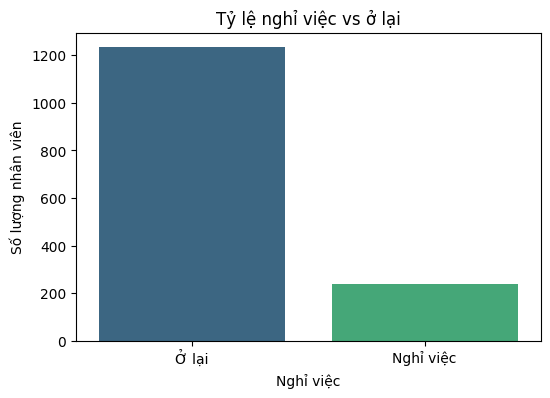


Phần trăm nhân viên nghỉ việc: 16.12%
Số lượng nhân viên nghỉ việc và không nghỉ việc (sau khi resample và loại bỏ ngoại lệ):


Attrition
1    641
0    641
Name: count, dtype: int64

C:\Users\kax20\AppData\Local\Temp\ipykernel_8272\2519625764.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled_outliers, x='Attrition', palette='viridis')


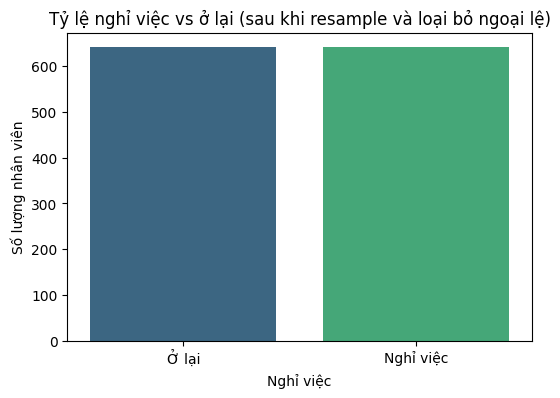

In [38]:
# 1. Đếm số lượng nhân viên nghỉ việc và không nghỉ việc
attrition_counts = df['Attrition'].value_counts()
print("Số lượng nhân viên nghỉ việc và không nghỉ việc:")
display(attrition_counts)

# 2. Vẽ biểu đồ cột cho tỷ lệ nghỉ việc
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Attrition', palette='viridis')
plt.title('Tỷ lệ nghỉ việc vs ở lại')
plt.xticks([0, 1], ['Ở lại', 'Nghỉ việc'])
plt.xlabel('Nghỉ việc')
plt.ylabel('Số lượng nhân viên')
plt.show()

# 3. Hiển thị phần trăm nhân viên nghỉ việc
if 1 in attrition_counts.index:
	attrition_percentage = (attrition_counts[1] / len(df)) * 100
	print(f"\nPhần trăm nhân viên nghỉ việc: {attrition_percentage:.2f}%")
else:
	print("\nKhông tìm thấy giá trị '1' trong cột 'Attrition'. Kiểm tra lại dữ liệu mã hóa.")

# làm lại với dữ liệu đã resample và clean outlier
attrition_counts_resampled = df_resampled_outliers['Attrition'].value_counts()
print("Số lượng nhân viên nghỉ việc và không nghỉ việc (sau khi resample và loại bỏ ngoại lệ):")
display(attrition_counts_resampled)
# vẽ biểu đồ
plt.figure(figsize=(6, 4))
sns.countplot(data=df_resampled_outliers, x='Attrition', palette='viridis')
plt.title('Tỷ lệ nghỉ việc vs ở lại (sau khi resample và loại bỏ ngoại lệ)')
plt.xticks([0, 1], ['Ở lại', 'Nghỉ việc'])
plt.xlabel('Nghỉ việc')
plt.ylabel('Số lượng nhân viên')
plt.show()

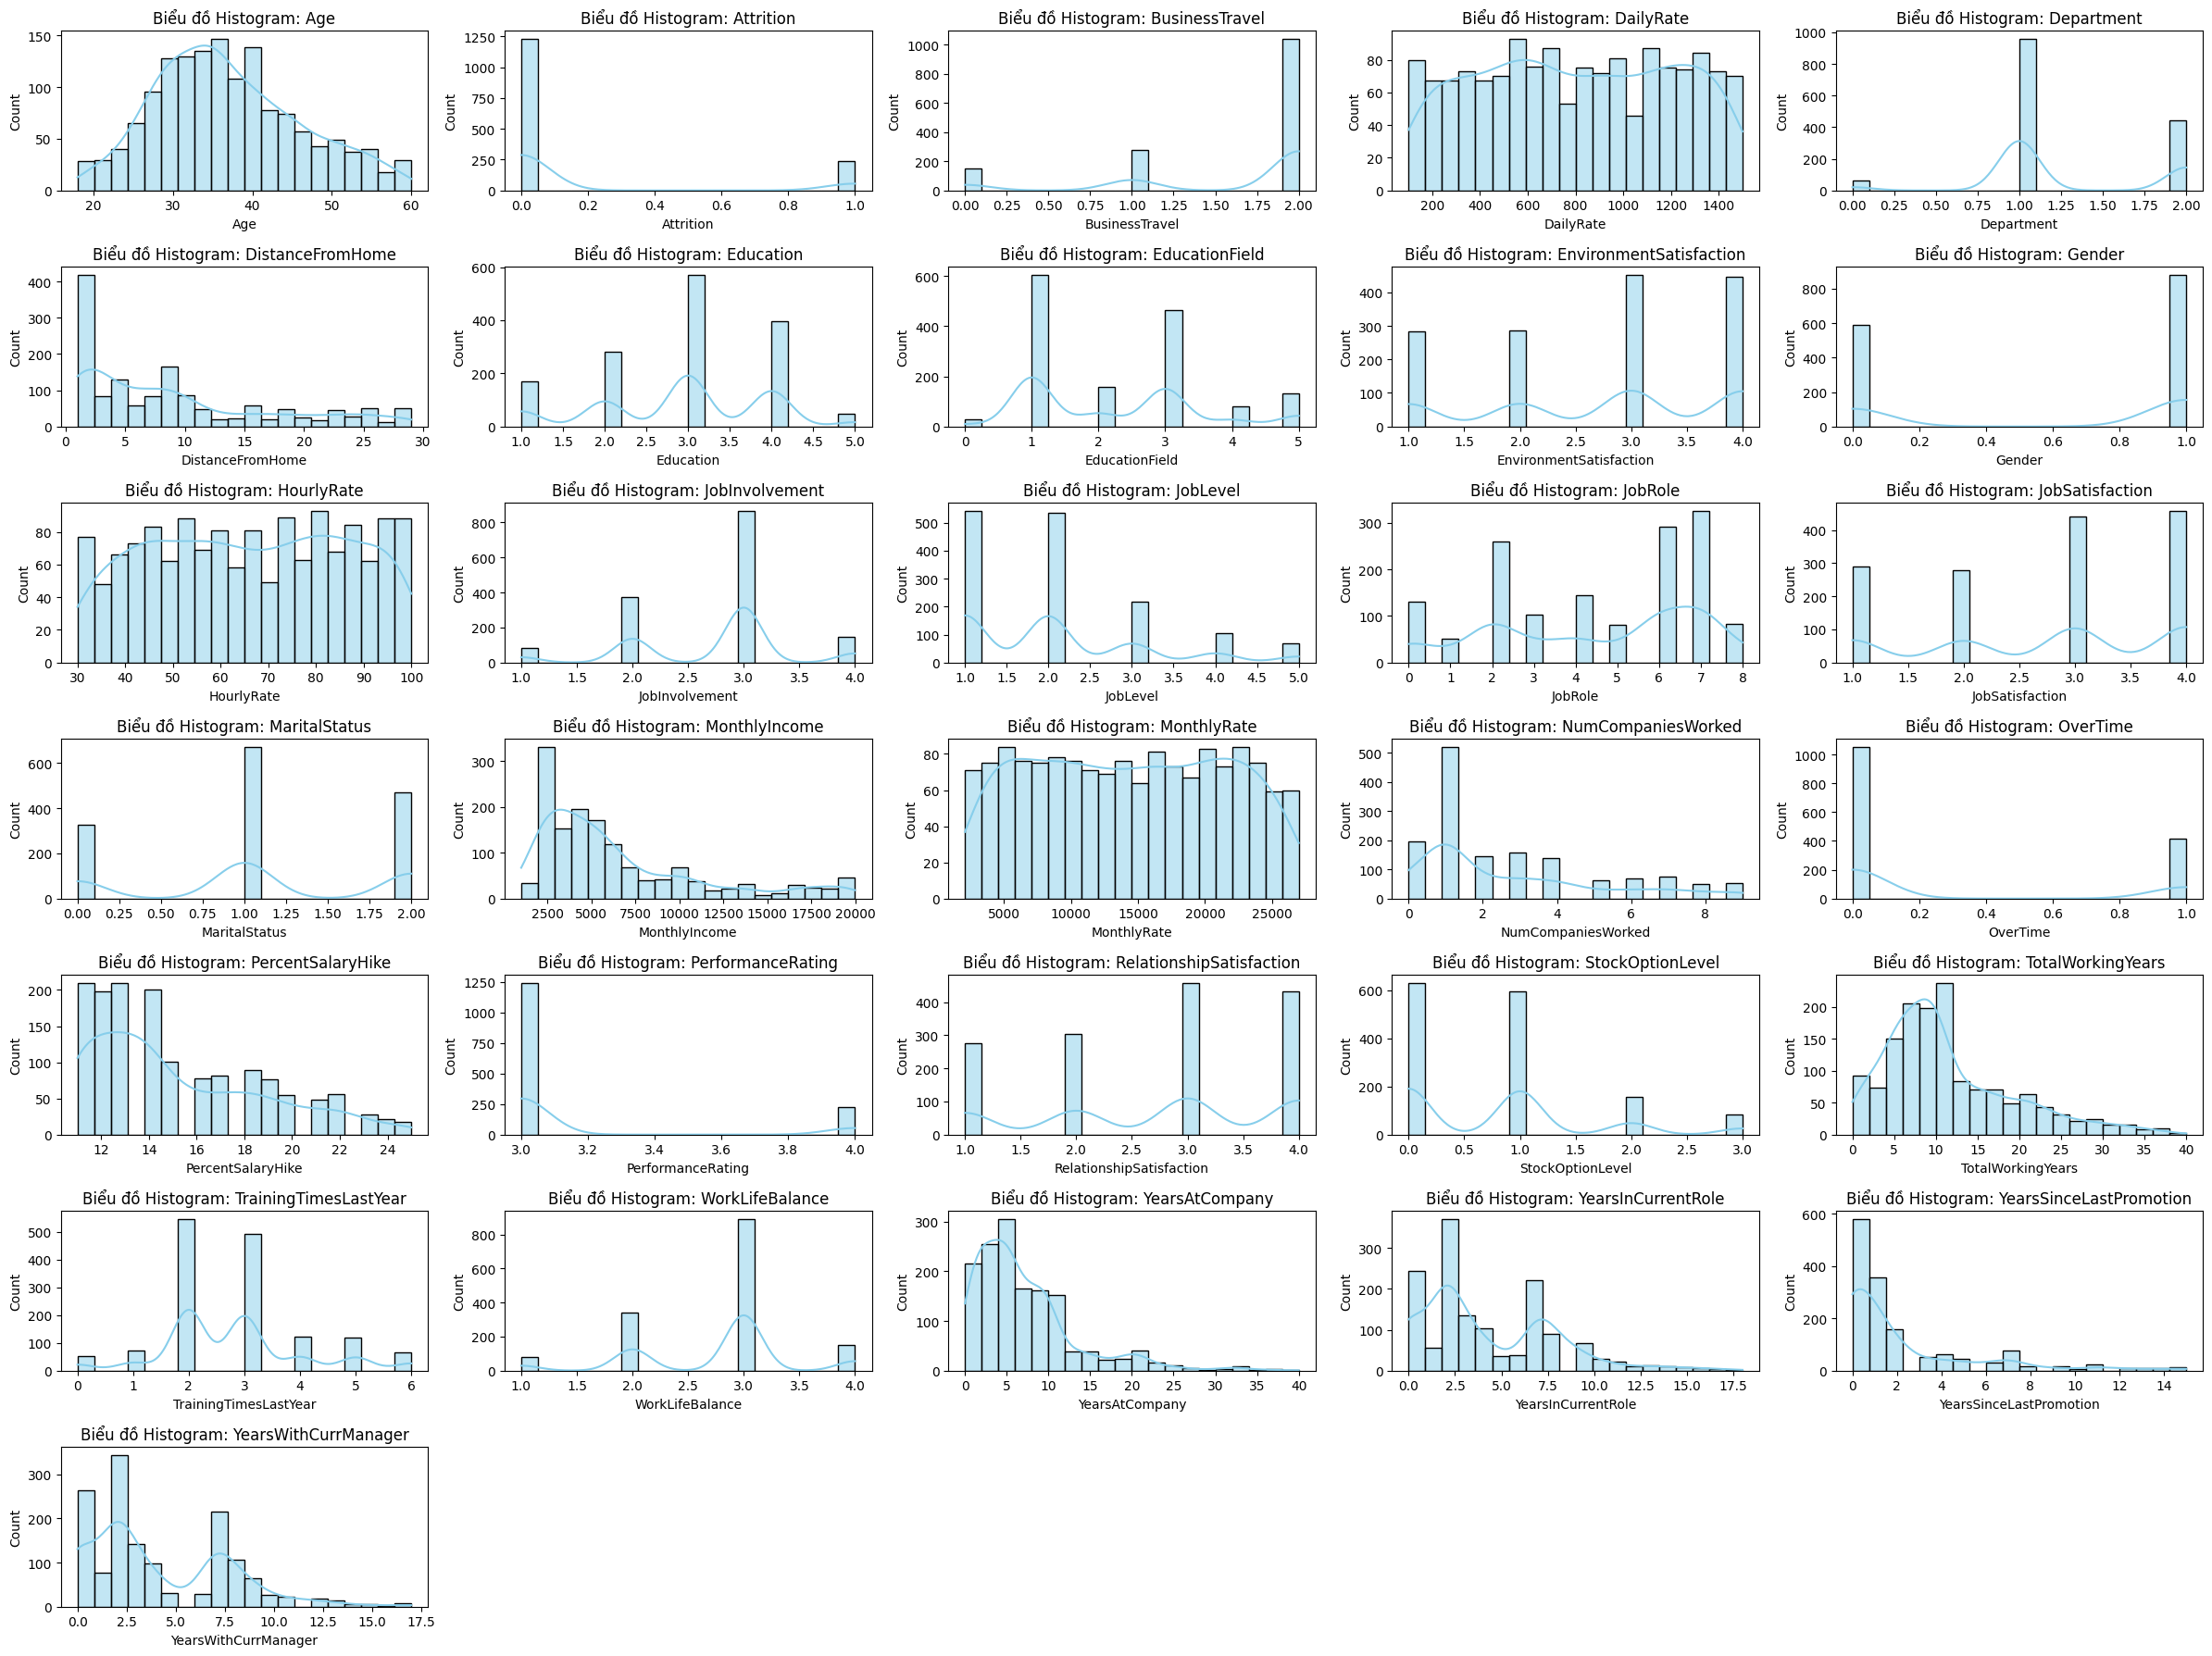

<Figure size 2400x1200 with 0 Axes>

In [39]:
# Lấy các biến số (loại trừ biến kiểu bool)
filtered_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Tính số hàng và cột cho subplot
import math
num_plots = len(filtered_numerical_cols)
cols = 5
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Biểu đồ Histogram: {col}')
plt.tight_layout()
plt.show()

# Vẽ countplot cho các biến phân loại (chỉ vẽ cho các biến đã được mã hóa nhị phân)
plt.figure(figsize=(24, 12))
for i, col in enumerate(df.columns[df.dtypes == 'bool']):
    plt.subplot(4, 5, i + 1)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Biểu đồ Countplot: {col}')
plt.tight_layout()
plt.show()

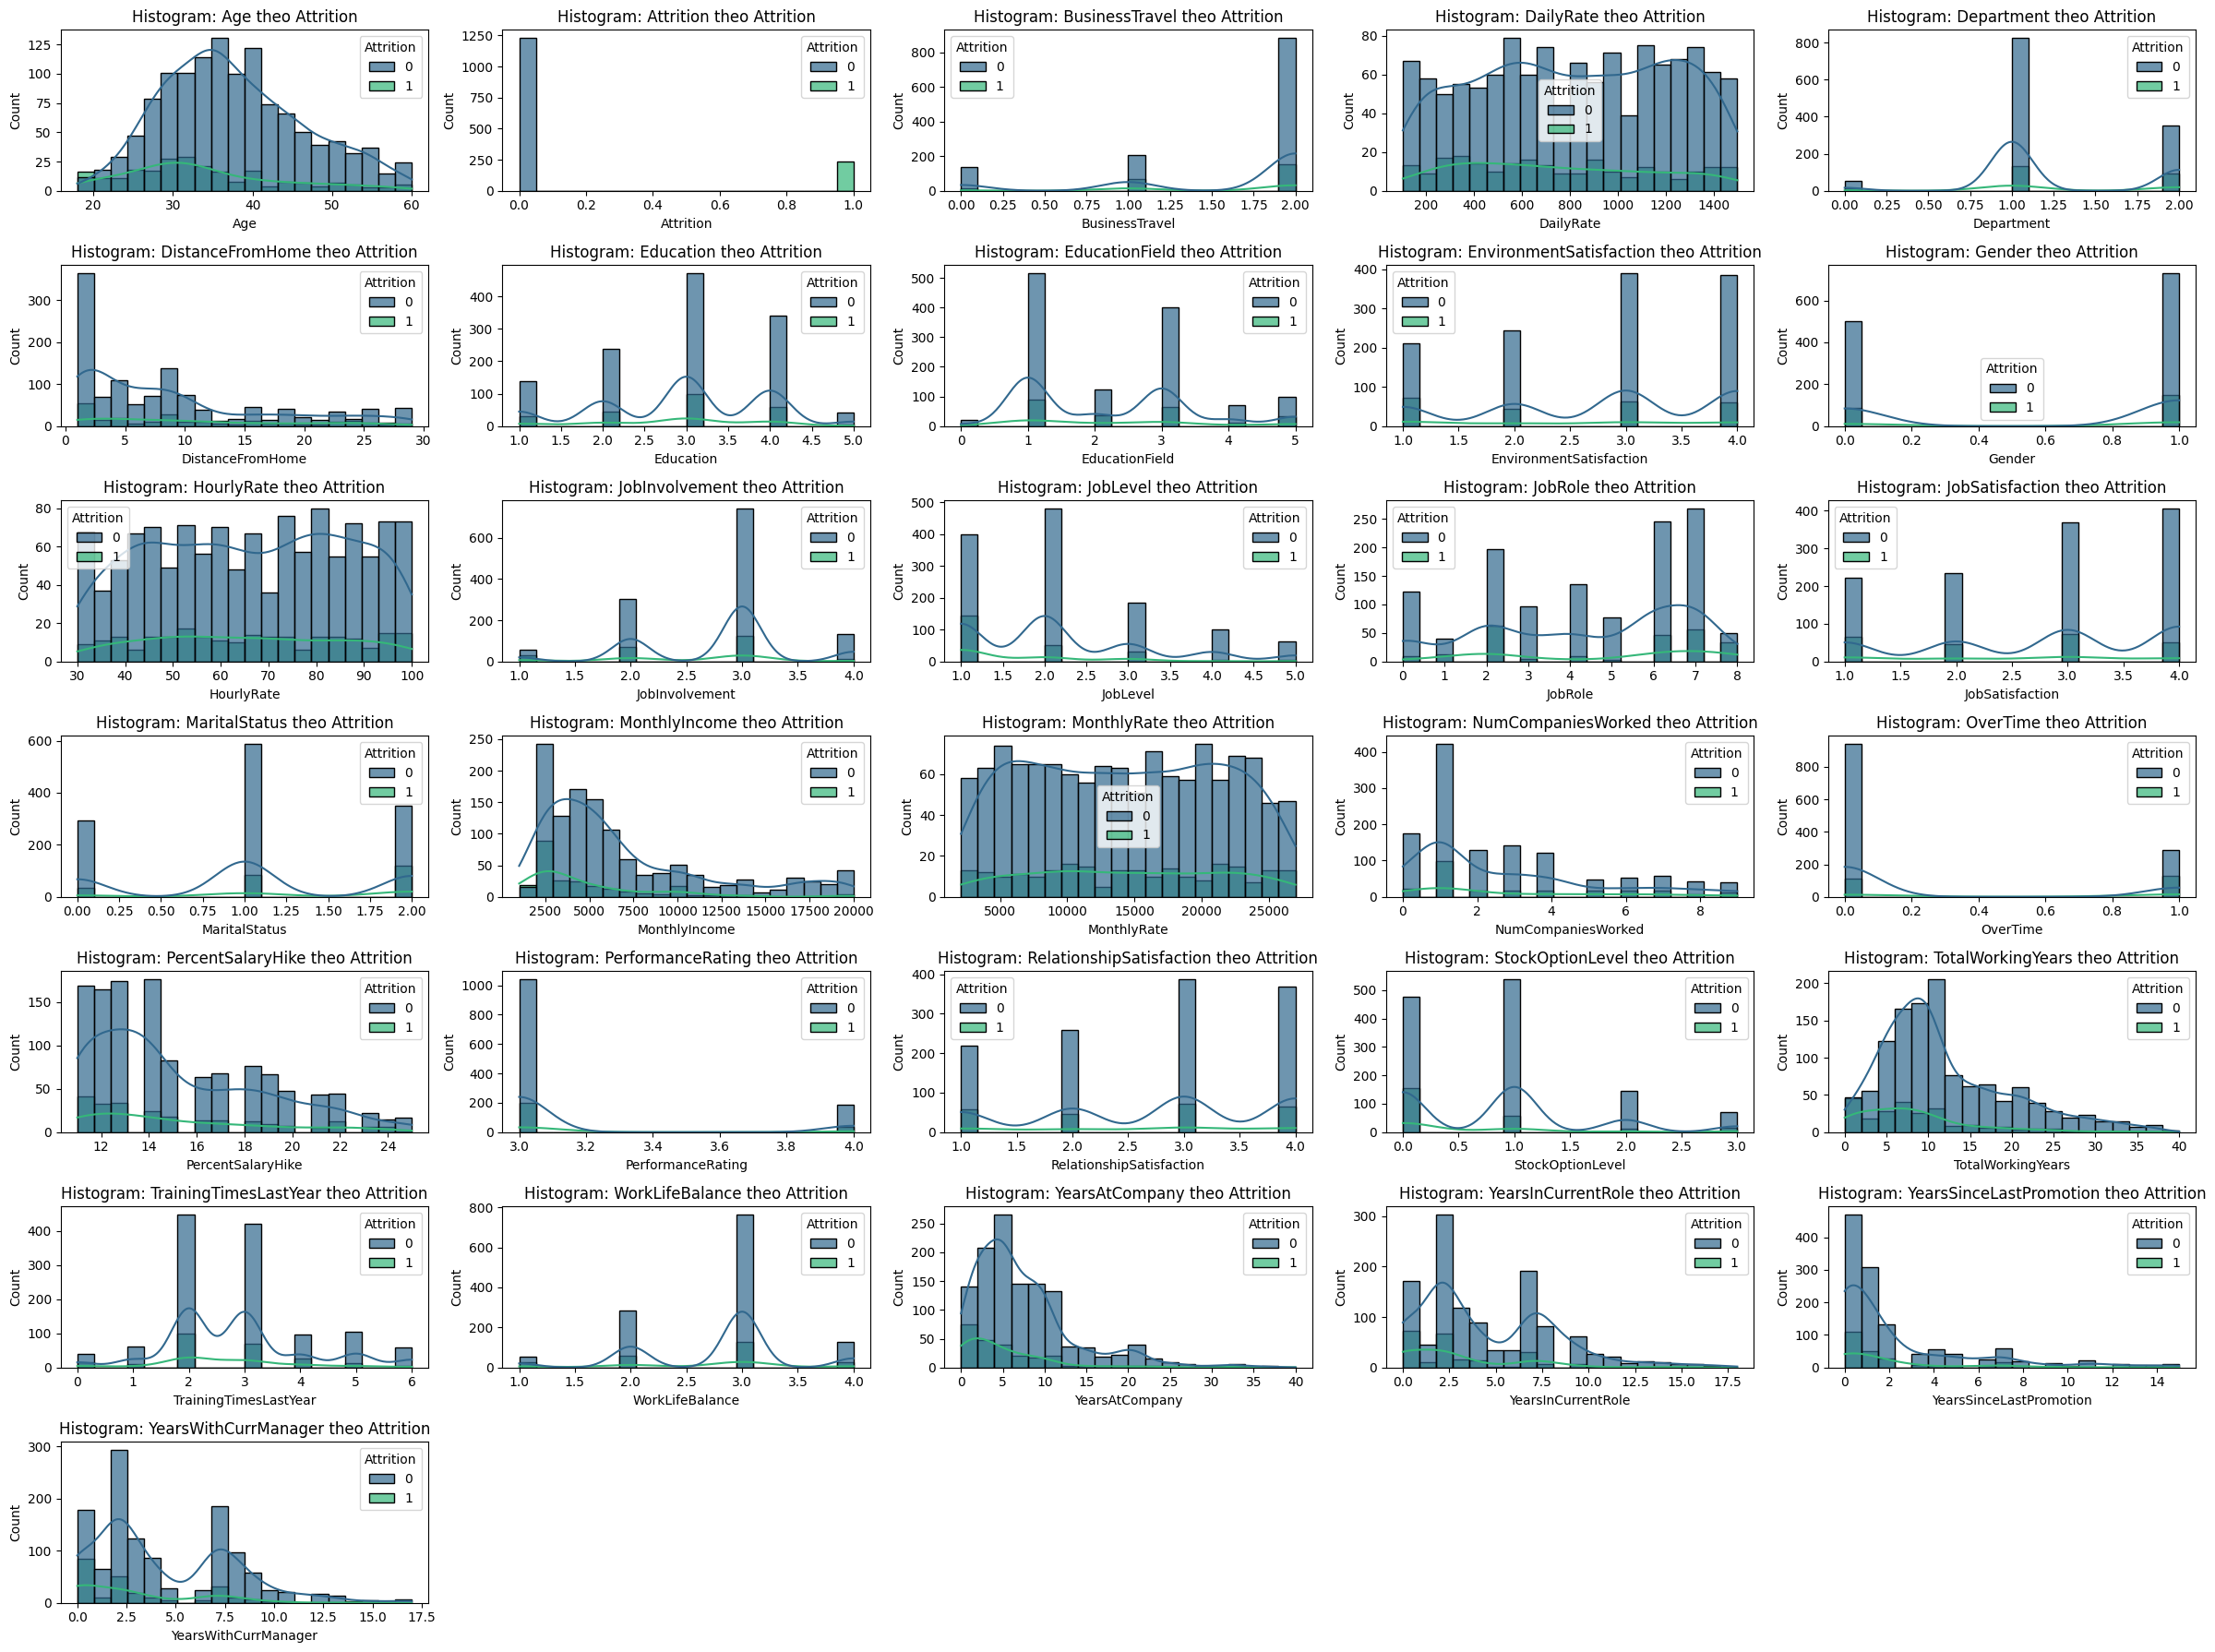

In [40]:
plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(data=df, x=col, hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
    plt.title(f'Histogram: {col} theo Attrition')
plt.tight_layout()
plt.show()

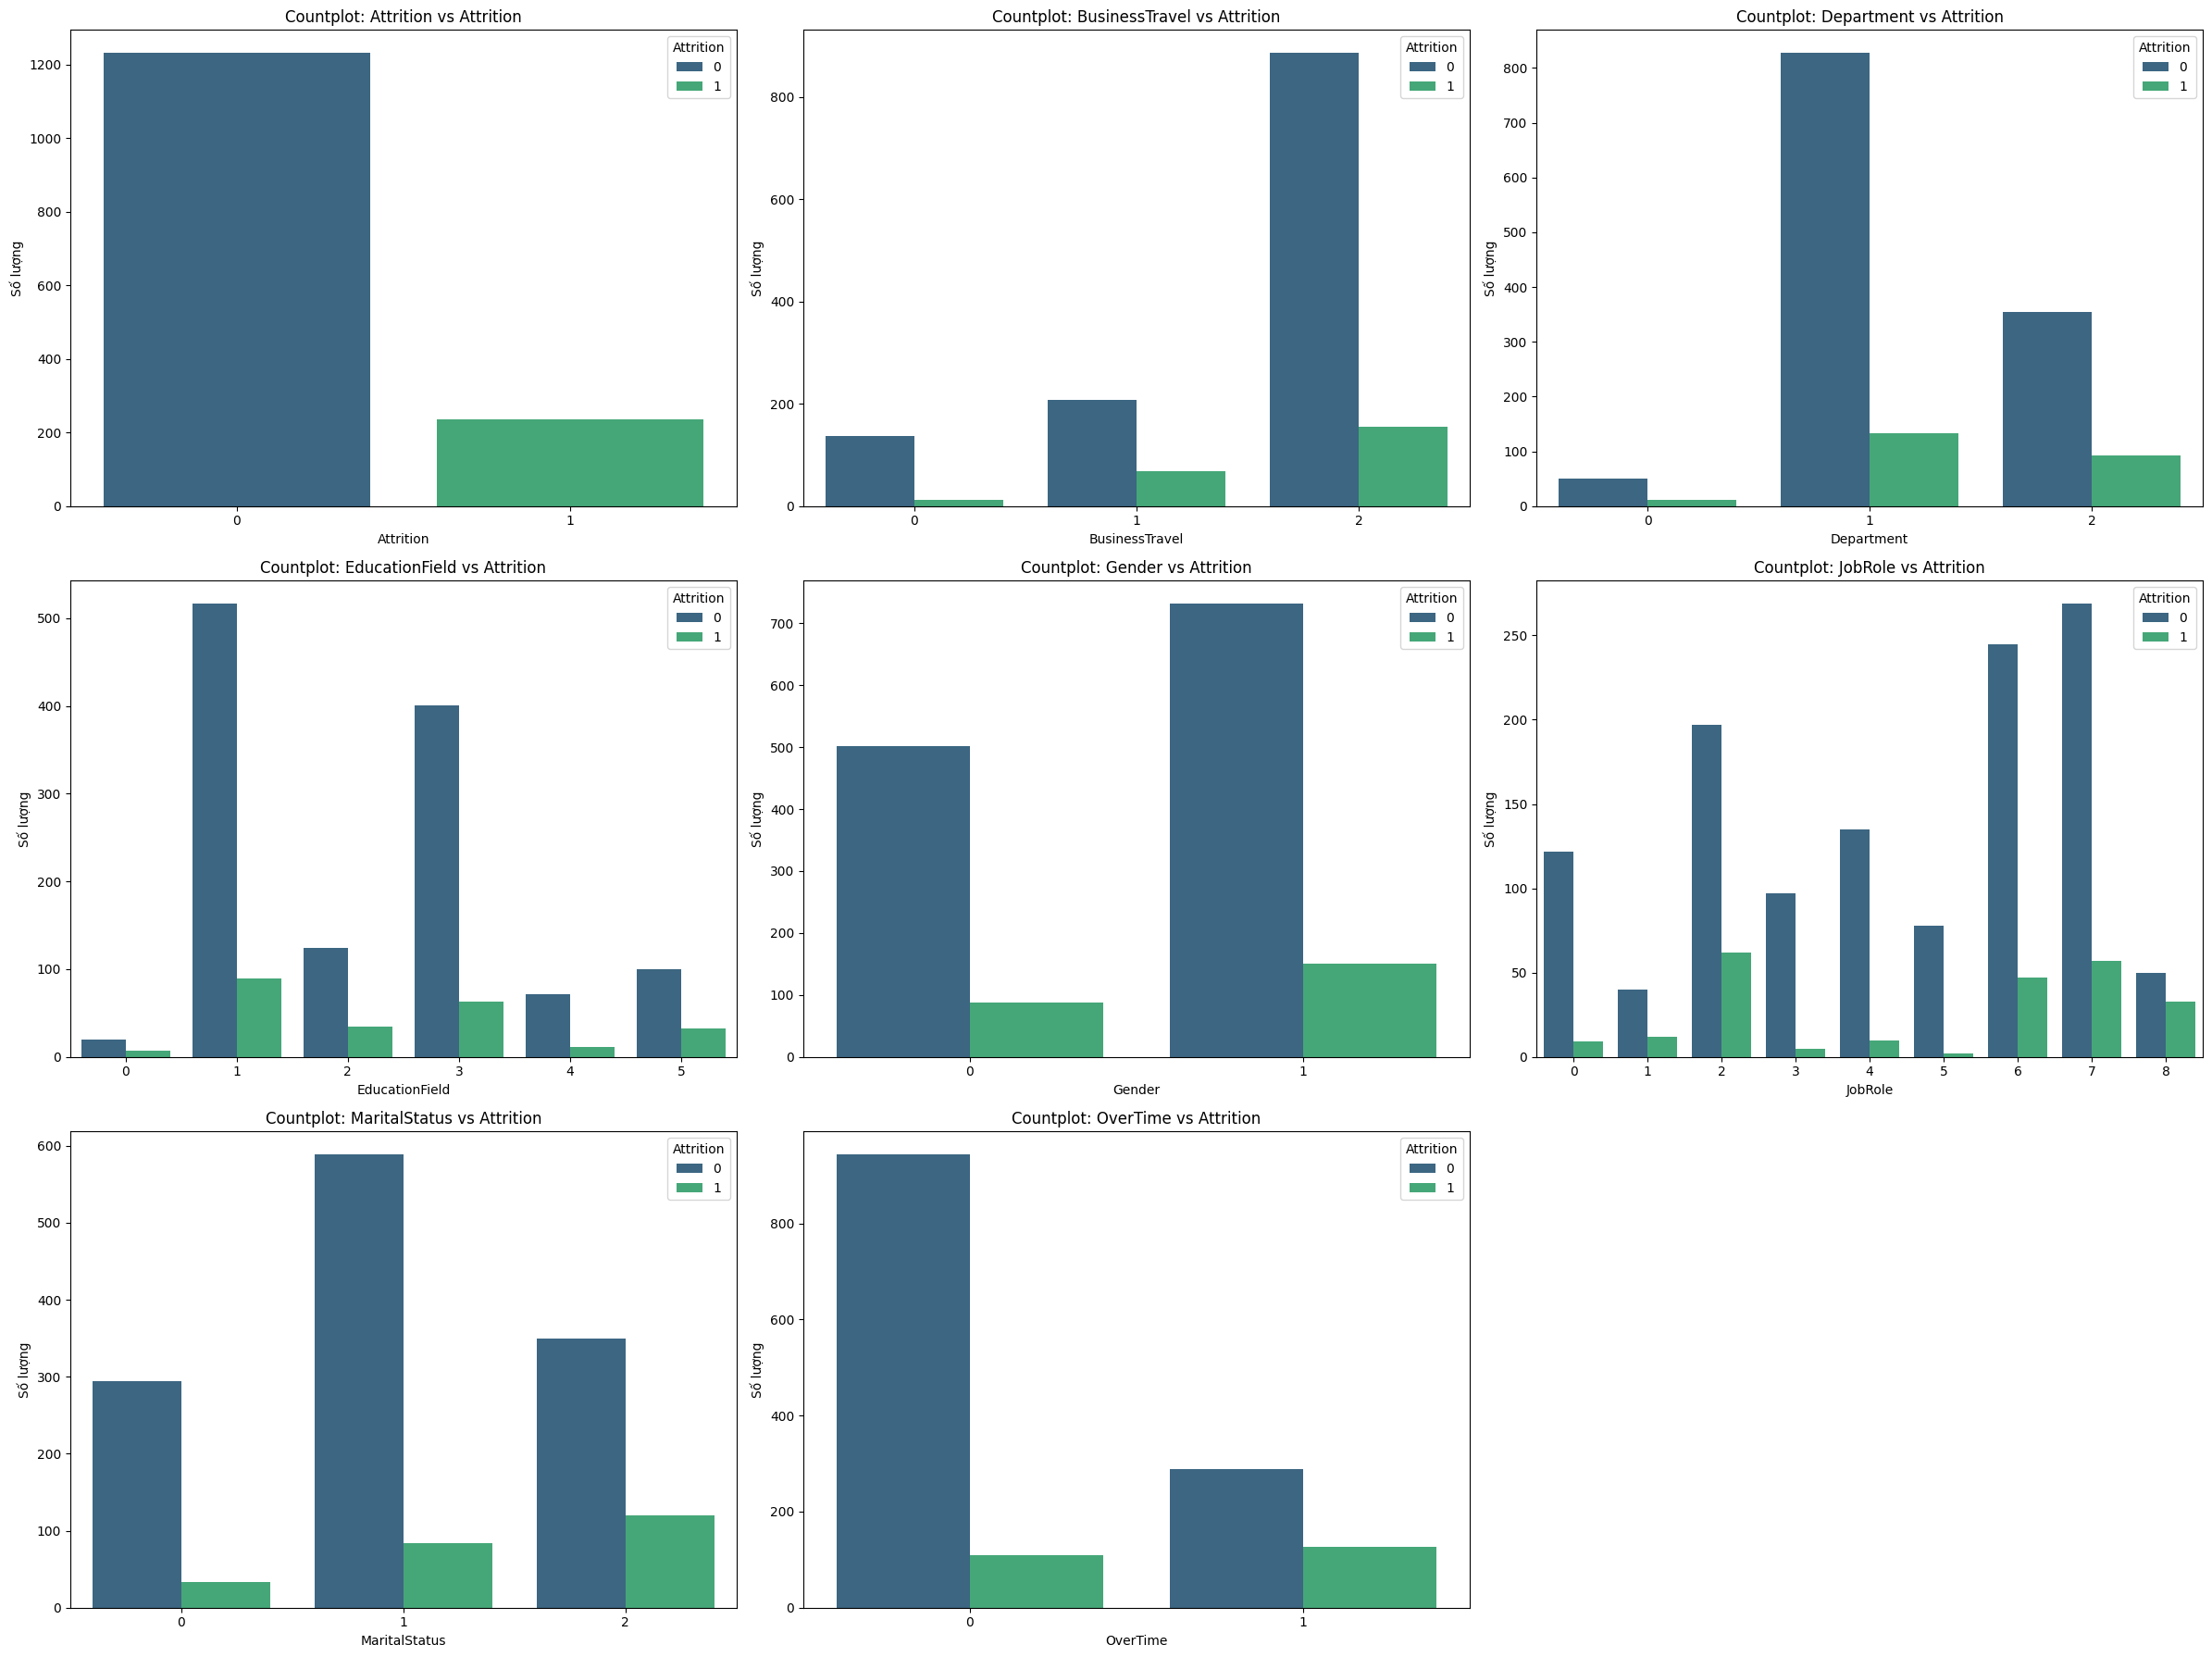

In [41]:
# Vẽ countplot giữa các biến phân loại và biến mục tiêu Attrition
plt.figure(figsize=(24, 18))
for idx, col in enumerate(categorical_cols):
    plt.subplot(3, 3, idx + 1)
    # Nếu cột đã được one-hot encoding, vẽ countplot cho từng biến mới liên quan
    related_cols = [c for c in df.columns if c.startswith(col + "_") or c == col]
    for rel_col in related_cols:
        sns.countplot(data=df, x=rel_col, hue='Attrition', palette='viridis')
        plt.title(f'Countplot: {rel_col} vs Attrition')
        plt.xlabel(rel_col)
        plt.ylabel('Số lượng')
    plt.title(f'Countplot: {col} vs Attrition')
    plt.xlabel(col)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

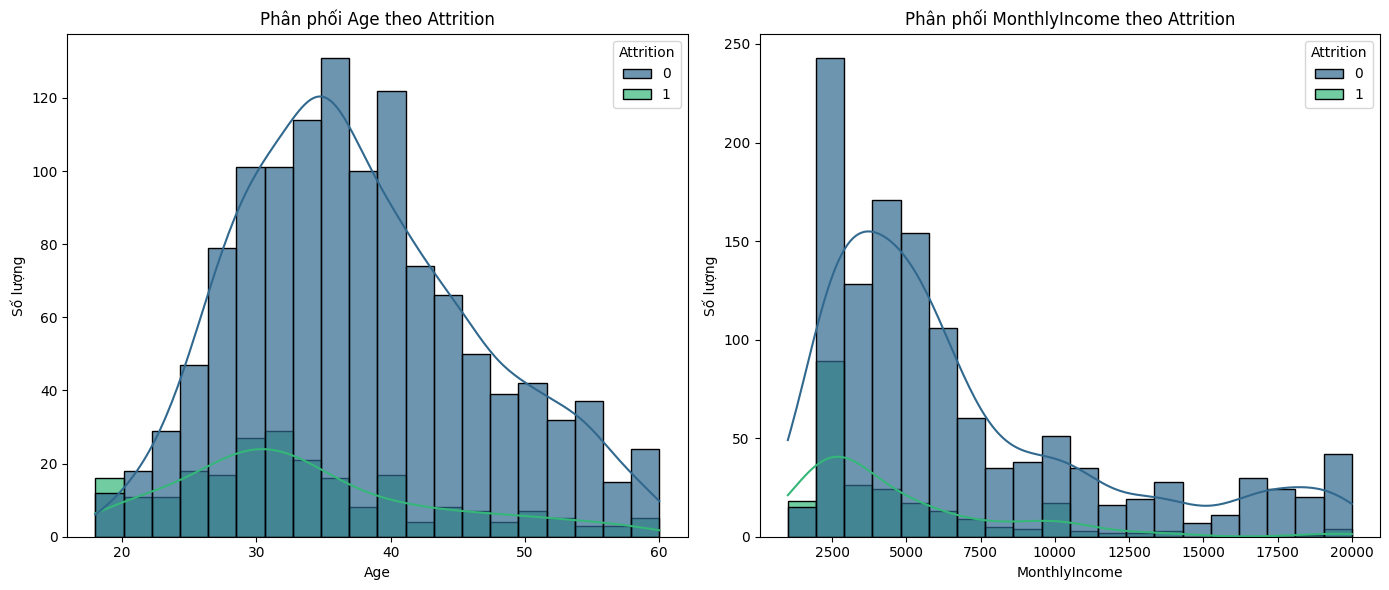

In [42]:
plt.figure(figsize=(14, 6))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối Age theo Attrition')
plt.xlabel('Age')
plt.ylabel('Số lượng')

# Histogram for MonthlyIncome
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='MonthlyIncome', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối MonthlyIncome theo Attrition')
plt.xlabel('MonthlyIncome')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

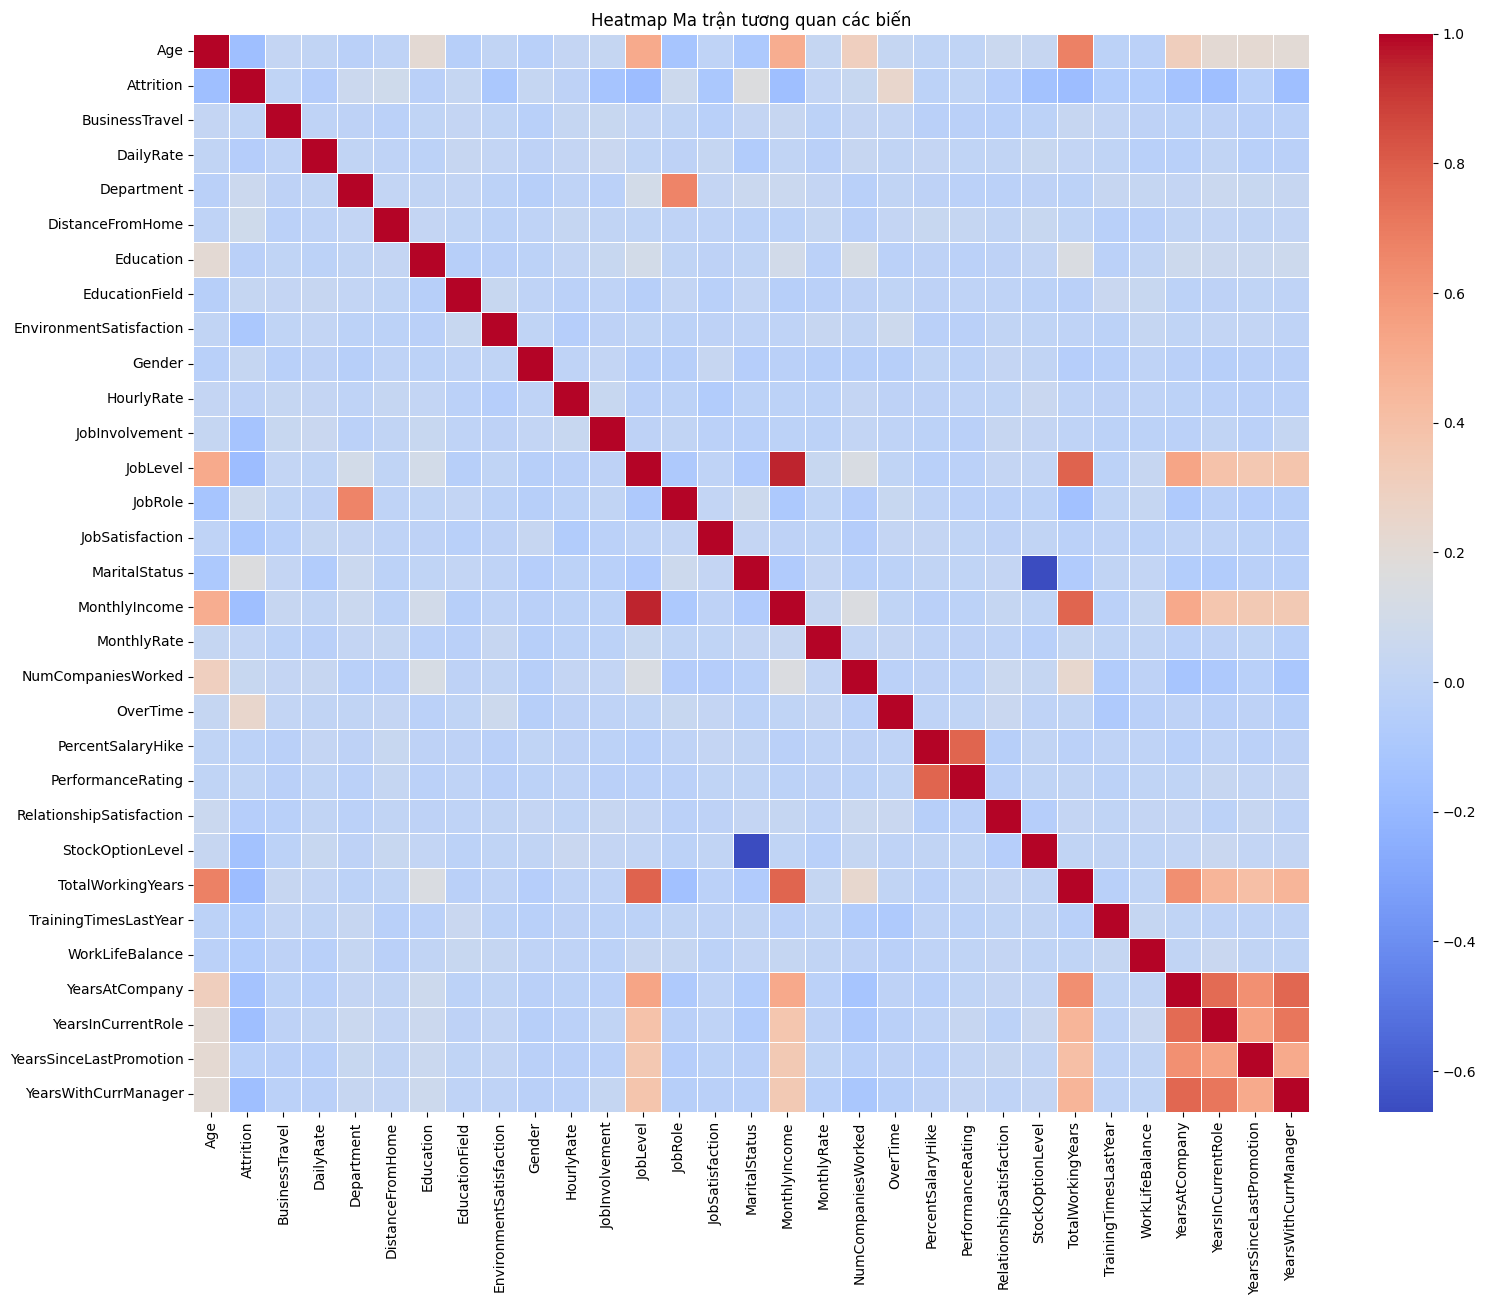

In [43]:
# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap với seaborn
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Ma trận tương quan các biến')
plt.show()

In [44]:

print("Phân phối của biến mục tiêu 'Attrition':")
print(df['Attrition'].value_counts(normalize=True))
print(df['Attrition'].value_counts())

Phân phối của biến mục tiêu 'Attrition':
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64
Attrition
0    1233
1     237
Name: count, dtype: int64


*Chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình*

In [45]:
# chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình
from sklearn.model_selection import train_test_split
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Số lượng mẫu trong tập huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra: {X_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp:\n{y_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp:\n{y_test.value_counts()}")

# chia bộ dữ liệu đã qua resample và loại bỏ outliers ra làm 2 phần 70/30
X_resampled_cleaned_outliers_train, X_resampled_cleaned_outliers_test, y_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_test = train_test_split(
	X_resampled_cleaned_outliers, y_resampled_cleaned_outliers, test_size=0.3, random_state=42, stratify=y_resampled_cleaned_outliers
)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): {X_resampled_cleaned_outliers_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): {X_resampled_cleaned_outliers_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_resampled_cleaned_outliers_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_resampled_cleaned_outliers_test.value_counts()}")

# chia bộ dữ liệu chỉ qua resample ra làm 2 phần 70/30
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(
	X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi resample): {X_resampled_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (sau khi resample): {X_resampled_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample):\n{y_resampled_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample):\n{y_resampled_test.value_counts()}")


Số lượng mẫu trong tập huấn luyện: 1029
Số lượng mẫu trong tập kiểm tra: 441
Số lượng mẫu trong tập huấn luyện theo lớp:
Attrition
0    863
1    166
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp:
Attrition
0    370
1     71
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): 897
Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): 385
Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
1    449
0    448
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
0    193
1    192
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi resample): 1726
Số lượng mẫu trong tập kiểm tra (sau khi resample): 740
Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample):
Attrition
1    863
0    863
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample):
Attrition


# Xây dựng mô hình (Build Model)

Mô hình hồi quy Logistic Regression

In [46]:
# Huấn luyện mô hình Logistic Regression và đánh giá
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred):.4f}")



Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       370
           1       0.85      0.24      0.37        71

    accuracy                           0.87       441
   macro avg       0.86      0.62      0.65       441
weighted avg       0.87      0.87      0.84       441

Ma trận nhầm lẫn:
[[367   3]
 [ 54  17]]
[[367   3]
 [ 54  17]]
Độ chính xác của mô hình: 0.8707


c:\Users\kax20\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
#Dùng data đã qua resample để train model 
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled_train, y_resampled_train)
y_pred = model.predict(X_resampled_test)
print("Báo cáo phân loại:")
print(classification_report(y_resampled_test, y_pred))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_test, y_pred))
print(confusion_matrix(y_resampled_test, y_pred))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_test, y_pred):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       370
           1       0.77      0.76      0.76       370

    accuracy                           0.76       740
   macro avg       0.76      0.76      0.76       740
weighted avg       0.76      0.76      0.76       740

Ma trận nhầm lẫn:
[[284  86]
 [ 88 282]]
[[284  86]
 [ 88 282]]
Độ chính xác của mô hình: 0.7649


c:\Users\kax20\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
# Dùng data đã qua resample và loại bỏ outliers để train model
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred = model.predict(X_resampled_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_resampled_cleaned_outliers_test, y_pred))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred))
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_cleaned_outliers_test, y_pred):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       193
           1       0.77      0.70      0.73       192

    accuracy                           0.75       385
   macro avg       0.75      0.75      0.74       385
weighted avg       0.75      0.75      0.74       385

Ma trận nhầm lẫn:
[[152  41]
 [ 57 135]]
[[152  41]
 [ 57 135]]
Độ chính xác của mô hình: 0.7455


c:\Users\kax20\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mô hình cây quyết định (Decision Tree)

In [ ]:
# Huấn luyện mô hình Decision Tree và đánh giá
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_dt))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_dt))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_dt):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       370
           1       0.27      0.24      0.25        71

    accuracy                           0.77       441
   macro avg       0.56      0.56      0.56       441
weighted avg       0.76      0.77      0.77       441

Ma trận nhầm lẫn:
[[323  47]
 [ 54  17]]
Độ chính xác của mô hình: 0.7710


In [ ]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_resampled_train, y_resampled_train)

y_pred_dt = model_dt.predict(X_resampled_test)

print("Báo cáo phân loại:")
print(classification_report(y_resampled_test, y_pred_dt))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_test, y_pred_dt))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_test, y_pred_dt):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       370
           1       0.76      0.85      0.80       370

    accuracy                           0.79       740
   macro avg       0.80      0.79      0.79       740
weighted avg       0.80      0.79      0.79       740

Ma trận nhầm lẫn:
[[273  97]
 [ 57 313]]
Độ chính xác của mô hình: 0.7919


In [ ]:
# Dùng data đã qua resample và clean outliers để train mô hình decision tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)

y_pred_dt = model_dt.predict(X_resampled_cleaned_outliers_test)

print("Báo cáo phân loại:")
print(classification_report(y_resampled_cleaned_outliers_test, y_pred_dt))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred_dt))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_cleaned_outliers_test, y_pred_dt):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       193
           1       0.75      0.79      0.77       192

    accuracy                           0.76       385
   macro avg       0.76      0.76      0.76       385
weighted avg       0.76      0.76      0.76       385

Ma trận nhầm lẫn:
[[143  50]
 [ 41 151]]
Độ chính xác của mô hình: 0.7636


Mô hình Random Forest

In [ ]:
#huấn luyện mô hình random forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_rf))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_rf):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       370
           1       0.50      0.13      0.20        71

    accuracy                           0.84       441
   macro avg       0.68      0.55      0.56       441
weighted avg       0.80      0.84      0.80       441

Ma trận nhầm lẫn:
[[361   9]
 [ 62   9]]
Độ chính xác của mô hình: 0.8390


In [ ]:
# Huấn luyện mô hình RandomForest và đánh giá với dữ liệu đã qua resample
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_resampled_train, y_resampled_train)
y_pred_rf = model_rf.predict(X_resampled_test)
print("Báo cáo phân loại:")
print(classification_report(y_resampled_test, y_pred_rf))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_test, y_pred_rf))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_test, y_pred_rf):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       370
           1       0.89      0.91      0.90       370

    accuracy                           0.90       740
   macro avg       0.90      0.90      0.90       740
weighted avg       0.90      0.90      0.90       740

Ma trận nhầm lẫn:
[[330  40]
 [ 34 336]]
Độ chính xác của mô hình: 0.9000


In [ ]:
# Huấn luyện mô hình RandomForest và đánh giá với dữ liệu đã qua resample và loại bỏ outliers
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_rf = model_rf.predict(X_resampled_cleaned_outliers_test) 
print("Báo cáo phân loại:")
print(classification_report(y_resampled_cleaned_outliers_test, y_pred_rf))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred_rf))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_cleaned_outliers_test, y_pred_rf):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       193
           1       0.94      0.82      0.88       192

    accuracy                           0.89       385
   macro avg       0.89      0.89      0.89       385
weighted avg       0.89      0.89      0.89       385

Ma trận nhầm lẫn:
[[183  10]
 [ 34 158]]
Độ chính xác của mô hình: 0.8857


# Xây dựng mô hình KNN 


In [ ]:
#huấn luyện mô hình KNN (K-Nearest Neighbors) với điểm k chạy từ 1 tới 30
from sklearn.neighbors import KNeighborsClassifier
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_train, y_train)
    y_pred_knn = model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_knn))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_knn))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_knn):.4f}")



Giá trị k tốt nhất: 8 với độ chính xác: 0.8435
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       370
           1       1.00      0.03      0.05        71

    accuracy                           0.84       441
   macro avg       0.92      0.51      0.48       441
weighted avg       0.87      0.84      0.78       441

Ma trận nhầm lẫn:
[[370   0]
 [ 69   2]]
Độ chính xác của mô hình: 0.8435


In [ ]:
# Huấn luyện mô hình KNN với dữ liệu đã qua resample cho K chạy từ 1 đến 30
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_resampled_train, y_resampled_train)
    y_pred_knn = model_knn.predict(X_resampled_test)
    accuracy = accuracy_score(y_resampled_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)
model_knn.fit(X_resampled_train, y_resampled_train)
y_pred_knn = model_knn.predict(X_resampled_test)
print("Báo cáo phân loại:")
print(classification_report(y_resampled_test, y_pred_knn))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_test, y_pred_knn))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_test, y_pred_knn):.4f}")


Giá trị k tốt nhất: 1 với độ chính xác: 0.7946
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       370
           1       0.75      0.89      0.81       370

    accuracy                           0.79       740
   macro avg       0.81      0.79      0.79       740
weighted avg       0.81      0.79      0.79       740

Ma trận nhầm lẫn:
[[259 111]
 [ 41 329]]
Độ chính xác của mô hình: 0.7946


In [ ]:
# Huan luyện mô hình KNN với dữ liệu đã qua resample và loại bỏ outliers cho K chạy từ 1 đến 30
best_k = 1
best_accuracy = 0
for k in range(1, 31):
    model_knn = KNeighborsClassifier(n_neighbors=k)
    model_knn.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
    y_pred_knn = model_knn.predict(X_resampled_cleaned_outliers_test)
    accuracy = accuracy_score(y_resampled_cleaned_outliers_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
print(f"Giá trị k tốt nhất: {best_k} với độ chính xác: {best_accuracy:.4f}")
model_knn = KNeighborsClassifier(n_neighbors=best_k)   
model_knn.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_knn = model_knn.predict(X_resampled_cleaned_outliers_test)
print("Báo cáo phân loại:")
print(classification_report(y_resampled_cleaned_outliers_test, y_pred_knn))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred_knn))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_cleaned_outliers_test, y_pred_knn):.4f}")


Giá trị k tốt nhất: 1 với độ chính xác: 0.7844
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       193
           1       0.77      0.80      0.79       192

    accuracy                           0.78       385
   macro avg       0.78      0.78      0.78       385
weighted avg       0.78      0.78      0.78       385

Ma trận nhầm lẫn:
[[148  45]
 [ 38 154]]
Độ chính xác của mô hình: 0.7844


In [ ]:
from sklearn.model_selection import GridSearchCV

# Tinh chỉnh mô hình sử dụng GridSearchCV cho Random Forest và Logistic Regression


# GridSearch cho Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")
print(f"Best accuracy for Random Forest: {grid_rf.best_score_:.4f}")

# GridSearch cho Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Logistic Regression: {grid_lr.best_params_}")
print(f"Best accuracy for Logistic Regression: {grid_lr.best_score_:.4f}")

# Đánh giá lại trên tập kiểm tra
best_rf = grid_rf.best_estimator_
best_lr = grid_lr.best_estimator_

y_pred_rf_best = best_rf.predict(X_resampled_test)
y_pred_lr_best = best_lr.predict(X_resampled_test)

print("\nRandom Forest sau tinh chỉnh:")
print(classification_report(y_resampled_test, y_pred_rf_best))
print(f"Độ chính xác: {accuracy_score(y_resampled_test, y_pred_rf_best):.4f}")

print("\nLogistic Regression sau tinh chỉnh:")
print(classification_report(y_resampled_test, y_pred_lr_best))
print(f"Độ chính xác: {accuracy_score(y_resampled_test, y_pred_lr_best):.4f}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy for Random Forest: 0.8998
Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.8024

Random Forest sau tinh chỉnh:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       370
           1       0.89      0.91      0.90       370

    accuracy                           0.90       740
   macro avg       0.90      0.90      0.90       740
weighted avg       0.90      0.90      0.90       740

Độ chính xác: 0.9000

Logistic Regression sau tinh chỉnh:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       370
           1       0.82      0.81      0.81       370

    accuracy                           0.81       740
   macro avg       0.81      0.81      0.81       740
weighted avg       0.81      0.81      0.81       74

# Xây dựng mô hình XGBoost


In [ ]:
# Huấn luyện mô hình XGBoost với dữ liệu chỉ qua tiền xử lý 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample và loại bỏ outliers
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_xgb))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_xgb))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_xgb):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.63      0.24      0.35        71

    accuracy                           0.85       441
   macro avg       0.75      0.61      0.63       441
weighted avg       0.83      0.85      0.83       441

Ma trận nhầm lẫn:
[[360  10]
 [ 54  17]]
Độ chính xác của mô hình: 0.8549


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:32:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample và loại bỏ outliers
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_resampled_train, y_resampled_train)
y_pred_xgb = model_xgb.predict(X_resampled_test)

print("Báo cáo phân loại:")
print(classification_report(y_resampled_test, y_pred_xgb))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_test, y_pred_xgb))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_test, y_pred_xgb):.4f}")


Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       370
           1       0.90      0.92      0.91       370

    accuracy                           0.91       740
   macro avg       0.91      0.91      0.91       740
weighted avg       0.91      0.91      0.91       740

Ma trận nhầm lẫn:
[[333  37]
 [ 31 339]]
Độ chính xác của mô hình: 0.9081


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Huấn luyện mô hình XGBoost với dữ liệu đã qua resample và loại bỏ outliers
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model_xgb.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
y_pred_xgb = model_xgb.predict(X_resampled_cleaned_outliers_test)

print("Báo cáo phân loại:")
print(classification_report(y_resampled_cleaned_outliers_test, y_pred_xgb))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_resampled_cleaned_outliers_test, y_pred_xgb))
print(f"Độ chính xác của mô hình: {accuracy_score(y_resampled_cleaned_outliers_test, y_pred_xgb):.4f}")

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       193
           1       0.91      0.82      0.86       192

    accuracy                           0.87       385
   macro avg       0.87      0.87      0.87       385
weighted avg       0.87      0.87      0.87       385

Ma trận nhầm lẫn:
[[178  15]
 [ 35 157]]
Độ chính xác của mô hình: 0.8701


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Xây dựng mô hình LightGBM

In [ ]:
# Huấn luyện mô hình LightGBM và đánh giá
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred_lgb))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_lgb))
print(f"Độ chính xác của mô hình: {accuracy_score(y_test, y_pred_lgb):.4f}")

Lưu lại các mô hình đã qua huấn luyện và các dataset qua các giai đoạn tiền xử lý khác nhau

In [ ]:
# Lưu mô hình đã huấn luyện sử dụng joblib
import joblib
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(best_lr, 'best_logistic_regression_model.pkl')
joblib.dump(model_knn, 'best_knn_model.pkl')
joblib.dump(model_dt, 'best_decision_tree_model.pkl')
# Lưu các bộ dữ liệu đã xử lý
df.to_csv('processed_dataset.csv', index=False)
df_resampled.to_csv('resampled_dataset.csv', index=False)
df_resampled_outliers.to_csv('resampled_cleaned_outliers_dataset.csv', index=False)
print("Mô hình và bộ dữ liệu đã được lưu thành công.")
# Load mô hình và dự đoán lại để kiểm tra
loaded_rf = joblib.load('best_random_forest_model.pkl')
loaded_lr = joblib.load('best_logistic_regression_model.pkl')
loaded_knn = joblib.load('best_knn_model.pkl')
loaded_dt = joblib.load('best_decision_tree_model.pkl')


Mô hình và bộ dữ liệu đã được lưu thành công.
